In [1]:
import sys
sys.path.append("../src")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
pasta = os.path.dirname(os.getcwd())

In [3]:
df_inicial = pd.read_excel(os.path.join(pasta, "src/table","Capital_share_bike__1___1_.xlsx"))

In [ ]:
#criando novas colunas para o dataframe
df_ajustado = df_inicial.copy()
df_ajustado['year'] = df_ajustado['datetime'].dt.year
df_ajustado['month'] = df_ajustado['datetime'].dt.month
df_ajustado['day'] = df_ajustado['datetime'].dt.day
df_ajustado['hour'] = df_ajustado['datetime'].dt.hour
df_ajustado['day_of_week_name'] = df_ajustado['datetime'].dt.day_name()
df_ajustado['day_of_week'] = df_ajustado['datetime'].dt.day_of_week 
df_ajustado['season_name'] = df_ajustado['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
df_ajustado['weather_name'] = df_ajustado['weather'].map({1: 'Clear', 2: 'Mist', 3: 'Rain', 4: 'Heavy Snow'})
df_ajustado['hour_sin'] = np.sin(2 * np.pi * df_ajustado['hour'] / 24)
df_ajustado['day_sin'] = np.sin(2 * np.pi * df_ajustado['day'] / 31)
df_ajustado['rush_hour'] = df_ajustado['hour'].apply(lambda x: 1 if x in [7, 8, 9, 17, 18, 19] else 0)
df_ajustado['temp_lag1'] = df_ajustado['temp'].shift(1).fillna(df_ajustado['temp'])
df_ajustado['humidity_lag1'] = df_ajustado['humidity'].shift(1).fillna(df_ajustado['humidity'])
df_ajustado['windspeed_lag1'] = df_ajustado['windspeed'].shift(1).fillna(df_ajustado['windspeed'])

In [5]:
df_ajustado = df_ajustado[df_ajustado['weather'] != 4]

In [36]:
def calculate_pls(df_agrupado, target_variable, drop_columns=None):
    """
    Perform Partial Least Squares (PLS) regression analysis on the provided DataFrame.

    This function separates the features and target variable, selects only numeric columns,
    fits a PLS regression model with a number of components equal to the minimum of 2 or 
    the available number of numeric features, and returns the ordered PLS coefficients.

    Parameters:
        df_agrupado (DataFrame): The DataFrame containing the data.
        target_variable (str): The name of the target variable.
        drop_columns (list, optional): List of columns to drop from the DataFrame 
                                       prior to analysis. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - ordered_coef (Series): The PLS regression coefficients ordered by their absolute value.
            - pls (PLSRegression): The fitted PLS regression model.
            - X_numeric (DataFrame): The numeric features used for the analysis.
            - y (Series): The target variable.
            
        If the target variable is not found in the DataFrame, the function prints an error message.
    """
    df = df_agrupado.copy()
    if target_variable not in df.columns:
        return print(f"Target variable '{target_variable}' not found. Please update the target column name accordingly.")
    else:
        # Separate features and the target variable
        if drop_columns is None:
            drop_columns = []
        X = df.drop(columns=[target_variable]+ drop_columns, errors='ignore')
        y = df[target_variable]

        # Use only numeric columns for our analysis
        X_numeric = X.select_dtypes(include=[np.number])
        
        # ----- PLS Regression Analysis -----
        # Choose number of components for PLS; adjust as needed
        n_components_pls = min(2, X_numeric.shape[1])
        pls = PLSRegression(n_components=n_components_pls)
        pls.fit(X_numeric, y)
        
        # Get PLS coefficients and display them
        pls_coef = pd.Series(pls.coef_.ravel(), index=X_numeric.columns)
        ordered_coef = pls_coef.reindex(pls_coef.abs().sort_values(ascending=False).index)
        
        return ordered_coef, pls, X_numeric, y
    
def xgb_results(X_numeric, y):
    """
    Evaluate an XGBoost regression model and return performance metrics.
    
    This function splits the provided numeric features (X_numeric) and target variable (y) 
    into training and testing sets (80/20 split), fits an XGBoost regressor on the training data, 
    and computes several regression performance metrics:
      - R² score
      - Root Mean Squared Error (RMSE)
      - Mean Absolute Error (MAE)
      - Weighted Mean Absolute Percentage Error (WMAPE)
      - Bias (mean prediction error)
    
    Parameters:
        X_numeric (DataFrame): A DataFrame containing only the numeric feature columns.
        y (Series): The target variable.
    
    Returns:
        str: A formatted string summarizing the model's performance metrics.
    """
    
    # Ensure X_numeric and y were defined in a previous cell (from your data)
    # Fit an XGBoost regression model
    model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            random_state=42)

    #calculate the model performance, r2, rmse, mae, bias


    X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(y_test)
    bias = np.mean(y_pred - y_test)
    

    return f"R2: {r2:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nWMAPE: {wmape:.2f}\nBias: {bias:.2f}"

def plot_pls_coefficients(ordered_coef, title, with_regression=False, X_numeric=None, y=None):
    """
    Plot the Partial Least Squares (PLS) regression coefficients.

    This function creates a bar plot of the ordered PLS coefficients and optionally overlays regression 
    performance metrics (obtained from an XGBoost model) if requested.

    Parameters:
        ordered_coef (Series): The ordered PLS regression coefficients (ordered by their absolute value).
        title (str): The title for the plot.
        with_regression (bool, optional): If True, computes and displays XGBoost regression performance metrics. 
                                          Defaults to False.
        X_numeric (DataFrame, optional): The DataFrame of numeric feature columns used in the analysis. 
                                         Required if with_regression is True.
        y (Series, optional): The target variable corresponding to X_numeric. 
                              Required if with_regression is True.

    Returns:
        None: The plot is displayed.
    """
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=ordered_coef.index, y=ordered_coef.values)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('PLS Coefficients')
    #remove the y ticks
    plt.yticks([])
    plt.tight_layout()
    
    for p in ax.patches:
        height = p.get_height()
        if height >= 0:
            ax.text(p.get_x() + p.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')
        else:
            ax.text(p.get_x() + p.get_width()/2, height, f'{height:.2f}', ha='center', va='top')

    if with_regression:
        metrics_text = xgb_results(X_numeric, y)
        ax = plt.gca()
        ax.text(0.95, 0.95, metrics_text, transform=ax.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


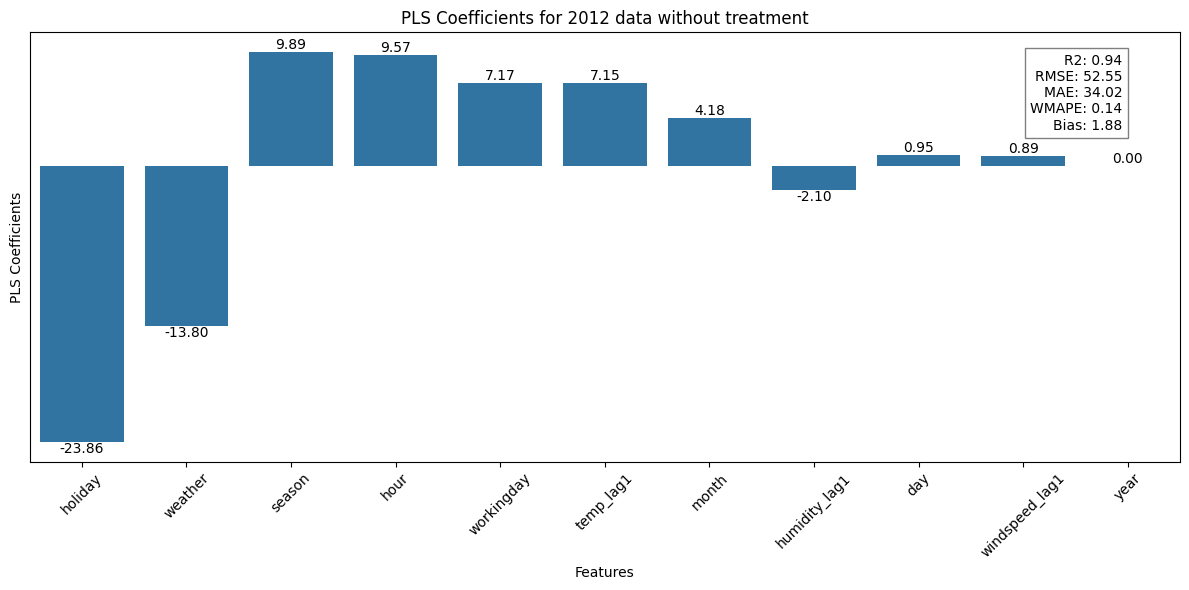

In [37]:
target_variable = 'count'  
df_inteiro = df_ajustado[df_ajustado['year'] == 2012].copy()

ordered_coef, pls, X_numeric, y = calculate_pls(df_inteiro, target_variable, ['day_of_week','hour_sin','day_sin','rush_hour','casual','registered','atemp','temp','windspeed','humidity'])
plot_pls_coefficients(ordered_coef, "PLS Coefficients for 2012 data without treatment",True, X_numeric, y)


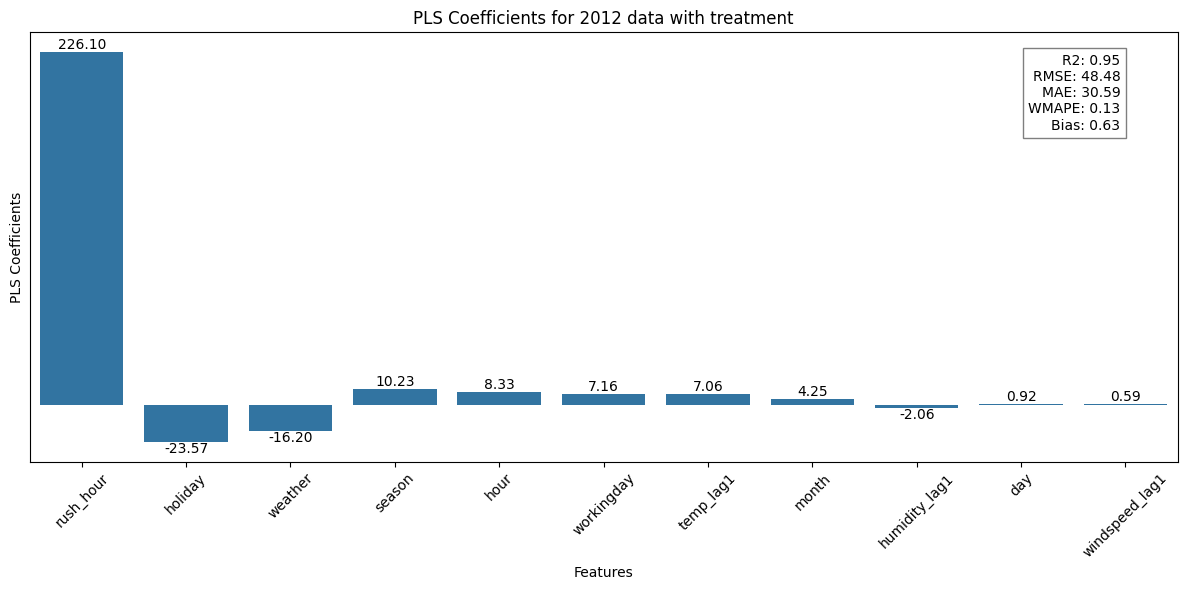

In [46]:
target_variable = 'count'  
columns_to_drop = ['datetime','year', 'casual', 'registered', 'day_of_week', 'day_of_week_name', 'season_name', 'weather_name', 'atemp', 'hour_sin', 'day_sin','temp', 'humidity', 'windspeed',]
metrics = ['temp_lag1','humidity_lag1','windspeed_lag1', 'count', 'registered', 'casual']
#create a new list of columns to group that should include all columns from df_ajustado excep columns_to_drop and metrics
group_columns = [col for col in df_ajustado.columns if col not in columns_to_drop and col not in metrics]

df_agrupado = df_ajustado[df_ajustado['year'] == 2012].copy()

df_agrupado = df_agrupado.groupby(group_columns).agg(
    {'temp_lag1': 'mean', 'humidity_lag1': 'mean', 'windspeed_lag1': 'mean',
     'count': 'mean', 'registered': 'mean', 'casual': 'mean'}).reset_index() 
ordered_coef, pls, X_numeric, y = calculate_pls(df_agrupado, target_variable, columns_to_drop)
plot_pls_coefficients(ordered_coef, "PLS Coefficients for 2012 data with treatment",True, X_numeric, y)

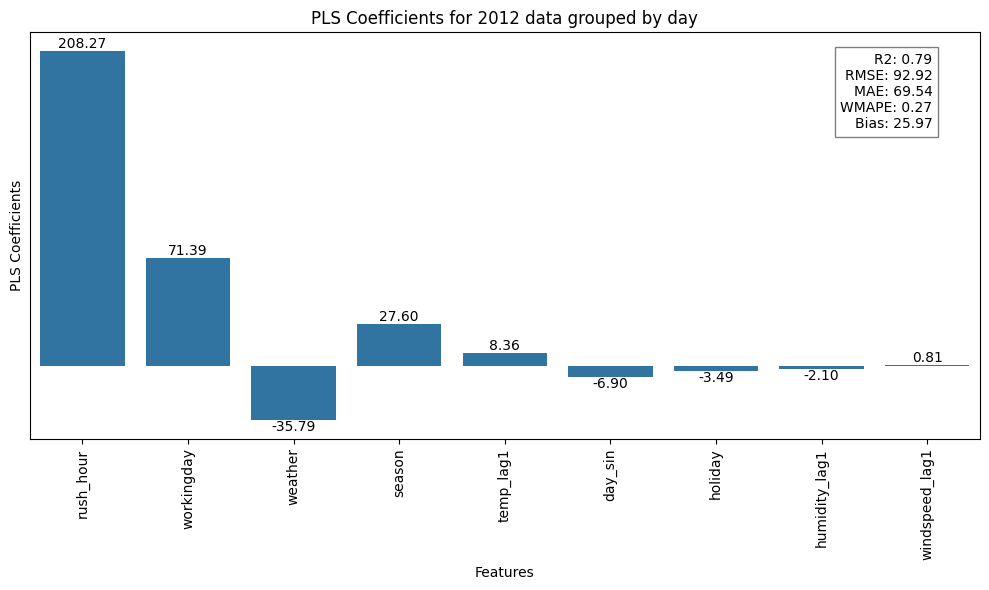

In [30]:
target_variable = 'count'  
columns_to_drop = ['datetime','year', 'casual', 'registered', 'day_of_week', 'day_of_week_name', 'season_name', 'weather_name', 'atemp', 'hour', 'day', 'month', 'hour_sin','temp', 'humidity', 'windspeed']
metrics = ['temp_lag1', 'humidity_lag1', 'windspeed_lag1', 'count', 'registered', 'casual']
#create a new list of columns to group that should include all columns from df_ajustado excep columns_to_drop and metrics
group_columns = [col for col in df_ajustado.columns if col not in columns_to_drop and col not in metrics]

df_agrupado = df_ajustado[df_ajustado['year'] == 2012].copy()
df_agrupado = df_agrupado.groupby(group_columns).agg(
    {'temp_lag1': 'mean', 'humidity_lag1': 'mean', 'windspeed_lag1': 'mean',
     'count': 'mean', 'registered': 'mean', 'casual': 'mean'}).reset_index() 
ordered_coef, pls, X_numeric, y = calculate_pls(df_agrupado, target_variable, columns_to_drop)
plot_pls_coefficients(ordered_coef, "PLS Coefficients for 2012 data grouped by day",True, X_numeric, y)